In [5]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [6]:
# read in all the words
words = open('data/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [7]:
len(words)

32033

In [8]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [9]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
... ---> a
..a ---> v
.av ---> a
ava ---> .
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .
... ---> c
..c ---> h
.ch ---> a
cha ---> r
har ---> l
arl ---> o
rlo ---> t
lot ---> t
ott ---> e
tte ---> .
... ---> m
..m ---> i
.mi ---> a
mia ---> .
... ---> a
..a ---> m
.am ---> e
ame ---> l
mel ---> i
eli ---> a
lia ---> .
... ---> h
..h ---> a
.ha ---> r
har ---> p
arp ---> e
rpe ---> r
per ---> .
... ---> e
..e ---> v
.ev ---> e
eve ---> l
vel ---> y
ely ---> n
lyn ---> .
... ---> a
..a ---> b
.ab ---> i
abi ---> g
big ---> a
iga ---> i
gai ---> l
ail ---> .
... ---> e
..e ---> m
.em ---> i
emi ---> l
mil ---> y
ily ---> .
... ---> e
..e ---> l
.el ---> i
eli ---> z
liz ---> a
iza ---> b
zab ---> e
abe ---> t
bet ---> h
eth ---> .

In [10]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [11]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [12]:
C = torch.rand((27, 2))
emb = C[X]
print(f"{emb.shape=} {emb.view(-1,6).shape=} {emb[1]=} {emb.view(-1,6)[1]}")

emb.shape=torch.Size([228146, 3, 2]) emb.view(-1,6).shape=torch.Size([228146, 6]) emb[1]=tensor([[0.5342, 0.2292],
        [0.5342, 0.2292],
        [0.9973, 0.1854]]) tensor([0.5342, 0.2292, 0.5342, 0.2292, 0.9973, 0.1854])


In [13]:
W1 = torch.rand((6, 100)) # 100 neurons each with  6 weights
b1 = torch.rand(100)

In [14]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [15]:
h

tensor([[0.9738, 0.9471, 0.9428,  ..., 0.4417, 0.9490, 0.9177],
        [0.9747, 0.9698, 0.9762,  ..., 0.4595, 0.9785, 0.9581],
        [0.9952, 0.9854, 0.9767,  ..., 0.5304, 0.9601, 0.9199],
        ...,
        [0.9953, 0.9762, 0.9939,  ..., 0.8011, 0.9761, 0.9720],
        [0.9968, 0.9853, 0.9895,  ..., 0.8227, 0.9759, 0.9517],
        [0.9951, 0.9701, 0.9864,  ..., 0.6858, 0.9700, 0.9657]])

In [16]:
h.shape

torch.Size([228146, 100])

In [17]:
W2 = torch.rand((100, 27))
b2 = torch.rand(27)

In [18]:
logits = h @ W2 + b2

In [19]:
logits.shape

torch.Size([228146, 27])

In [20]:
counts = logits.exp()

In [21]:
prob = counts / counts.sum(1, keepdims=True)

In [22]:
prob.shape

torch.Size([228146, 27])

In [23]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [32], [228146]

In [ ]:
# ------------ now made respectable :) ---------------

In [ ]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [29]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.rand((27, 10), generator=g)
W1 = torch.rand((30, 200), generator=g)
b1 = torch.rand(200, generator=g)
W2 = torch.rand((200, 27), generator=g)
b2 = torch.rand(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [30]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [31]:
for p in parameters:
  p.requires_grad = True

In [32]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [33]:
lri = []
lossi = []
stepi = []

In [37]:
for i in range(20):
  
  # minibatch construct
  # ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr)
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

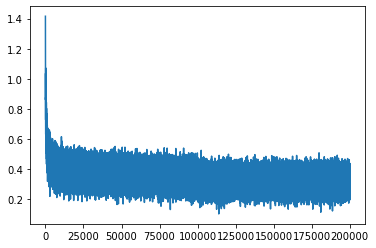

In [ ]:
plt.plot(stepi, lossi)

In [ ]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0753, grad_fn=<NllLossBackward0>)

In [ ]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1203, grad_fn=<NllLossBackward0>)

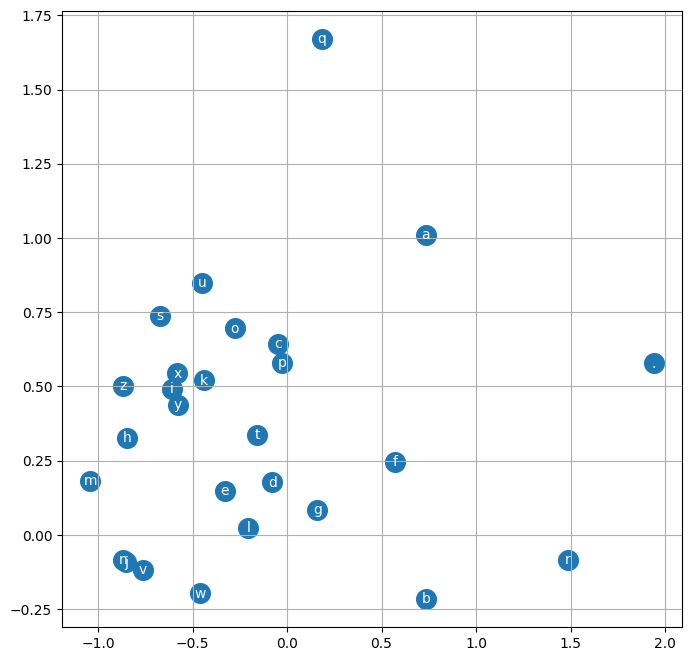

In [ ]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [ ]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [ ]:


# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmahela.
jhovi.
kimrin.
thil.
halanna.
jazhien.
amerynci.
aqui.
nellara.
chaiiv.
kaleigh.
ham.
joce.
quinton.
lilea.
jamilio.
jeron.
jaryni.
jace.
chrudeley.
